<a href="https://colab.research.google.com/github/AdityaJain2373/Sttai_lab11/blob/main/STT_Assignment_11_23110351_23110016.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

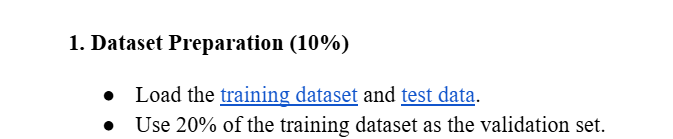

In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Load datasets
train_url = "https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/train.tsv"
test_url = "https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/test.tsv"

df = pd.read_csv(train_url, sep='\t', names=["sentence", "label"])
train_data, val_data = train_test_split(df, test_size=0.2, random_state=42)

# TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=10000)
X_train = vectorizer.fit_transform(train_data["sentence"]).toarray()
X_val = vectorizer.transform(val_data["sentence"]).toarray()

# Labels
y_train = train_data["label"].values
y_val = val_data["label"].values

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)

# DataLoaders
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=64)

In [16]:
print(f"X_train size: {X_train.shape}")
print(f"X_val size: {X_val.shape}")

X_train size: torch.Size([5536, 10000])
X_val size: torch.Size([1384, 10000])


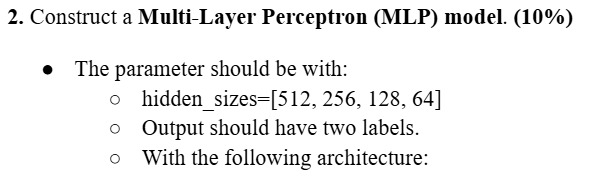

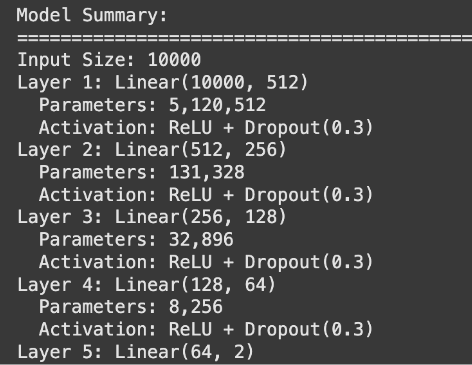

In [2]:
class MLP(nn.Module):
    def __init__(self, input_size=10000, hidden_sizes=[512, 256, 128, 64], output_size=2):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(hidden_sizes[1], hidden_sizes[2]),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(hidden_sizes[2], hidden_sizes[3]),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(hidden_sizes[3], output_size)
        )

    def forward(self, x):
        return self.model(x)


model = MLP()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay = 1e-4)
criterion = nn.CrossEntropyLoss()

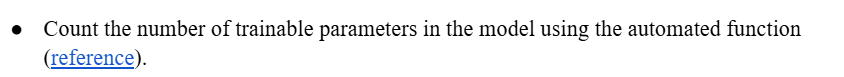

In [3]:
def count_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Trainable parameters:", count_trainable_params(model))

Trainable parameters: 5293122


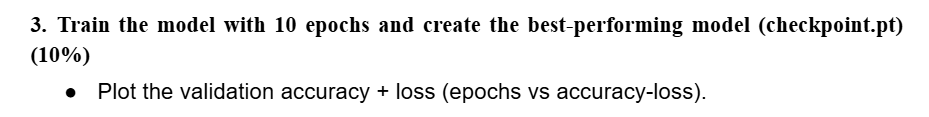

Epoch 1/7 - Train Loss: 0.6946, Train Accuracy: 48.05% - Val Loss: 0.6937, Val Accuracy: 48.48%
Epoch 2/7 - Train Loss: 0.6935, Train Accuracy: 49.37% - Val Loss: 0.6927, Val Accuracy: 59.25%
Epoch 3/7 - Train Loss: 0.6918, Train Accuracy: 52.94% - Val Loss: 0.6905, Val Accuracy: 51.52%
Epoch 4/7 - Train Loss: 0.6835, Train Accuracy: 57.14% - Val Loss: 0.6740, Val Accuracy: 59.75%
Epoch 5/7 - Train Loss: 0.6226, Train Accuracy: 75.16% - Val Loss: 0.5812, Val Accuracy: 75.58%
Epoch 6/7 - Train Loss: 0.4307, Train Accuracy: 88.96% - Val Loss: 0.4457, Val Accuracy: 80.13%
Epoch 7/7 - Train Loss: 0.2378, Train Accuracy: 93.08% - Val Loss: 0.4458, Val Accuracy: 79.41%


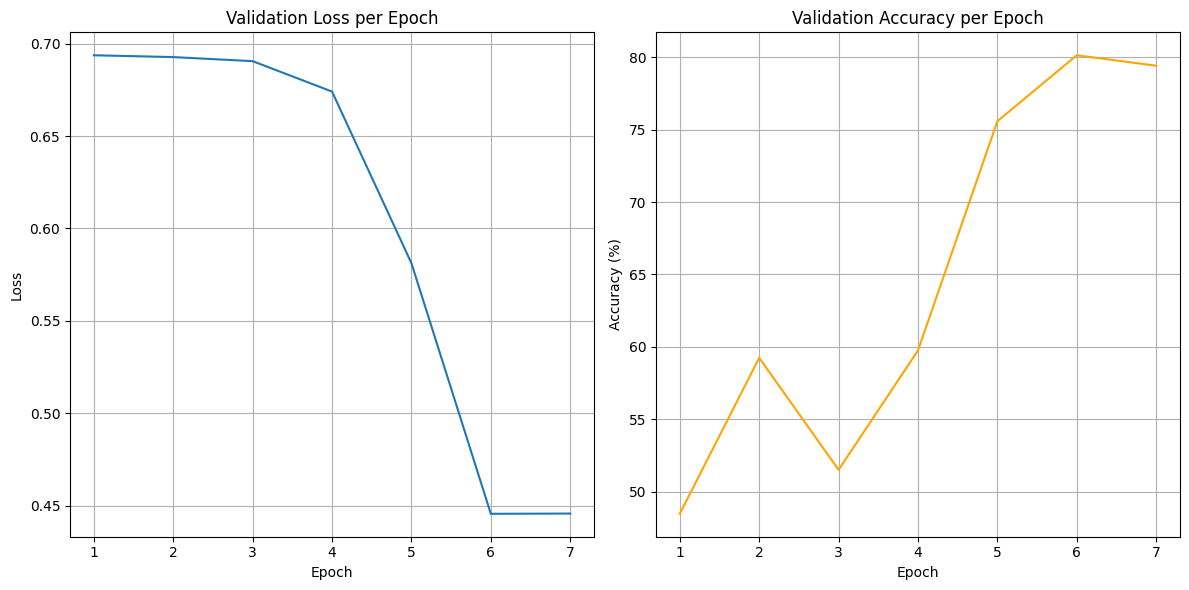

In [4]:
import matplotlib.pyplot as plt

patience = 3
best_val_loss = float('inf')
epochs_without_improvement = 0

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 7
for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted = torch.max(output, 1)
        correct_train += (predicted == y_batch).sum().item()
        total_train += y_batch.size(0)

    train_loss = total_train_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            output = model(X_batch)
            loss = criterion(output, y_batch)
            total_val_loss += loss.item()
            _, predicted = torch.max(output, 1)
            correct_val += (predicted == y_batch).sum().item()
            total_val += y_batch.size(0)

    val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{epochs} - "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}% - "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping at epoch {epoch+1} due to no improvement.")
        break

plt.figure(figsize=(12, 6))

# Plot Validation Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Validation Loss per Epoch")
plt.grid(True)

# Plot Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Validation Accuracy", color='orange')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy per Epoch")
plt.grid(True)

plt.tight_layout()
plt.show()

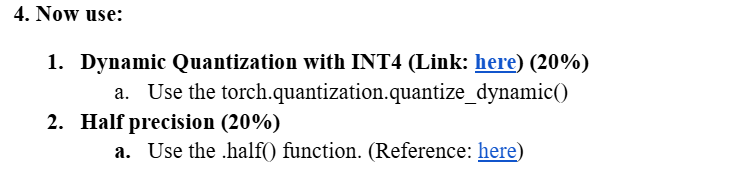

In [10]:
import torch.quantization

model_fp32 = MLP()
model_fp32.load_state_dict(torch.load("checkpoint.pt"))
model_fp32.eval()

model_int8 = torch.quantization.quantize_dynamic(
    model_fp32,
    {torch.nn.Linear},
    dtype=torch.qint8
)

model_half = MLP().half()
model_half.load_state_dict(torch.load("checkpoint.pt"))
model_half.eval()

MLP(
  (model): Sequential(
    (0): Linear(in_features=10000, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=128, out_features=64, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=64, out_features=2, bias=True)
  )
)

In [11]:
def evaluate(model, loader, use_half=False):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for xb, yb in loader:
            if use_half:
                xb = xb.half()
            preds = model(xb).argmax(1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
    return 100 * correct / total

In [12]:
import os

def get_size_mb(file_path):
    return os.path.getsize(file_path) / 1e6

# Save models
torch.save(model.state_dict(), "original.pt")
torch.save(model_int8.state_dict(), "dynamic.pt")
torch.save(model_half.state_dict(), "half.pt")

sizes = {
    "Original": get_size_mb("original.pt"),
    "Dynamic": get_size_mb("dynamic.pt"),
    "Half": get_size_mb("half.pt")
}

In [13]:
import time

start_time = time.time()
evaluate(model, val_loader)
original_time = time.time() - start_time

start_time = time.time()
evaluate(model_int8, val_loader)
dynamic_time = time.time() - start_time

start_time = time.time()
evaluate(model_half, val_loader, use_half=True)
half_time = time.time() - start_time

In [14]:
print(f"{'Model':<10} | {'Accuracy (%)':<14} | {'Storage (MB)':<16} | {'Inference Time (ms)':<20}")
print("-" * 70)
print(f"{'Original':<10} | {evaluate(model, val_loader):<14.2f} | {sizes['Original']:<16.2f} | {original_time * 1000:<20.2f}")
print(f"{'Dynamic':<10} | {evaluate(model_int8, val_loader, ):<14.2f} | {sizes['Dynamic']:<16.2f} | {dynamic_time * 1000:<20.2f}")
print(f"{'Half':<10}    | {evaluate(model_half, val_loader, use_half=True, ):<14.2f} | {sizes['Half']:<16.2f} | {half_time * 1000:<20.2f}")

Model      | Accuracy (%)   | Storage (MB)     | Inference Time (ms) 
----------------------------------------------------------------------
Original   | 79.41          | 21.18            | 208.63              
Dynamic    | 51.52          | 5.30             | 140.73              
Half          | 51.52          | 10.59            | 1695.66             
